# Setup instructions
## Conda environment
I used an Anaconda environment and generated a `.yml` file with the necessary dependencies. Just make sure you have a `conda` distribution ([Anaconda](https://www.anaconda.com/distribution/#download-section), [Miniconda](https://docs.conda.io/en/latest/miniconda.html), etc.) and run the following command to install the environment:

```shell 
conda env create -f environment.yml
```

After creating the environment, run `conda activate nuenv` to activate it. With the environment activated, run `jupyter notebook`.

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, style='whitegrid')

## Reading the training data

In [2]:
df_train = pd.read_csv('puzzle_train_dataset.csv')

## Remove clients that do not have the target variable

In [3]:
df_train.dropna(axis=0, subset=['default'], inplace=True)
df_train['default'] = df_train['default'].astype(bool)
feature_columns = df_train.columns.drop(['ids', 'default'])

In [4]:
df_train.dtypes

ids                    object
default                  bool
score_1                object
score_2                object
score_3               float64
score_4               float64
score_5               float64
score_6               float64
risk_rate             float64
amount_borrowed       float64
borrowed_in_months    float64
credit_limit          float64
reason                 object
income                float64
sign                   object
gender                 object
facebook_profile       object
state                  object
zip                    object
channel                object
job_name               object
real_state             object
ok_since              float64
n_bankruptcies        float64
n_defaulted_loans     float64
n_accounts            float64
n_issues              float64
dtype: object

## Describing the categorical columns
- The column `sign` has a lot of missing data, so I decided to drop it. I also wonder if it would be useful at all for default prediction...
- The column `channel` is equal to all the clients, so I dropped it.
- The column `facebook_profile` has around 10% of missing data. I will fill it with a placeholder.
- The column `gender` has around 5% of missing data. I will fill it with a placeholder.
- The column `job_name` has around 6% of missing data. I will fill it with a placeholder.
- The column `reason` has only 5 missing values out of 59966. Because of the small amount, I decided to fill in with a placeholder. 
- In the column `reason`, out of its 19496 unique values, more than 16700 are unique to a client. So I decided to replace the less frequent with a new category,
- The feature `job_name` has more than 42000 unique values, where almost 38000 are unique to a single person. So I will replace the less frequent values with a new category.

In [5]:
categorical_columns = df_train.select_dtypes('object').columns
describe_df = df_train[categorical_columns].describe().T
describe_df['missing_rate'] = (len(df_train) - describe_df['count']) / len(df_train)
describe_df

,count,unique,top,freq,missing_rate
ids,59966,59966,daf0e525-68b3-115e-b608-85bae9663cdf,1,0
score_1,59966,7,DGCQep2AE5QRkNCshIAlFQ==,20484,0
score_2,59966,35,osCzpM4hJrxugqWWuZmMWw==,5058,0
reason,59961,19496,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,5921,8.33806e-05
sign,41028,12,libr,5582,0.315812
gender,56970,2,m,38497,0.0499616
facebook_profile,53995,2,False,33997,0.0995731
state,59966,50,xsd3ZdsI3356I3xMxZeiqQ==,10212,0
zip,59966,830,3k2JCQ8Bp5oDwaI39ZJgHA==,775,0
channel,59966,1,NCqL3QBx0pscDnx3ixKwXg==,59966,0


### More than 16700 reasons are unique to one person

In [6]:
df_train['reason'].value_counts().value_counts()

1      16772
2       1193
3        467
4        225
5        157
       ...  
441        1
58         1
74         1
106        1
119        1
Name: reason, Length: 124, dtype: int64

### Almost 38000 job names are unique to one person

In [7]:
df_train['job_name'].value_counts().value_counts()

1     37935
2      2460
3       746
4       311
5       196
      ...  
78        1
81        1
47        1
79        1
40        1
Name: job_name, Length: 65, dtype: int64

### Remove the columns `sign` and `channel` from training

In [8]:
feature_columns = feature_columns.drop(['sign', 'channel'])

## Describing the numerical columns
- The column `ok_since` has a missing rate bigger than 58%, so I decided to remove it.
- By analysing the missing data in the columns `n_bankruptcies`, `n_defaulted_loans` and `n_issues`, I noticed that they are missing only for clients with missing data in `credit_limit`. Among the clients without the `credit_limit` information, the values of `n_defaulted_loans` are only NaN and 0, so I decided it to fill it with a placeholder; regarding the values of `n_bankruptcies`, it is zero for more than 95% of the clients withou credit limit, so I filled it with a placeholder as well.
- I strongly believe that the feature `n_issues` is an engineered feature of Nubank clients, such as the amount of complainings via chat or amount of disputed charges on his/her credit card. Because of this reason, I decided not to use it, considering fresh clients that request a loan.
- In addition, due to the high amount of missing data in the `credit_limit` column, I decided to not use it. A nice test would be to use the output of Nubank's credit limit regression model to fill in these gaps and see if it would improve the default prediction.
- The `income` column has an extremely high value, which is most likely an outlier. My decision was to clip the `income` column on 2000000.

In [9]:
numerical_columns = df_train.select_dtypes('number').columns
describe_df = df_train[numerical_columns].describe().T
describe_df['missing_rate'] = (len(df_train) - describe_df['count']) / len(df_train)
describe_df

,count,mean,std,min,25%,50%,75%,max,missing_rate
score_3,59966.0,346.435147,109.842822,0.000000,270.000000,340.000000,420.000000,9.900000e+02,0.000000
score_4,59966.0,99.999870,3.174459,86.191572,97.856471,100.008497,102.134785,1.139782e+02,0.000000
score_5,59966.0,0.498721,0.288653,0.000035,0.250013,0.497755,0.748461,9.999734e-01,0.000000
score_6,59966.0,99.943175,10.035178,60.663039,93.213368,99.979923,106.691523,1.424301e+02,0.000000
risk_rate,59966.0,0.294114,0.101183,0.000000,0.220000,0.290000,0.360000,9.000000e-01,0.000000
amount_borrowed,59966.0,13411.805468,7957.402823,527.070000,7225.987500,12012.400000,18036.645000,3.505960e+04,0.000000
borrowed_in_months,59966.0,40.674649,9.504775,36.000000,36.000000,36.000000,36.000000,6.000000e+01,0.000000
credit_limit,41187.0,34093.005997,36783.480509,0.000000,9907.000000,25338.000000,46759.500000,6.131170e+05,0.313161
income,59966.0,71325.776783,51691.429992,4821.180000,44027.857500,60047.260000,85039.612500,5.000028e+06,0.000000
ok_since,24877.0,35.276762,21.630884,0.000000,17.000000,32.000000,50.000000,1.410000e+02,0.585148


### Income boxplot

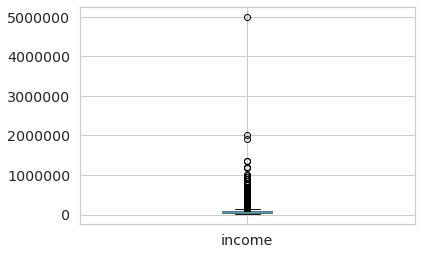

In [10]:
df_train['income'].plot(kind='box')

### Bankruptcies amont clients without `credit_limit`

In [11]:
df_train[df_train['credit_limit'].isna()]['n_bankruptcies'].unique()

array([ 0.,  1., nan,  2.])

In [12]:
df_train[df_train['credit_limit'].isna()]['n_bankruptcies'].value_counts() / len(df_train[df_train['credit_limit'].isna()])

0.0    0.954577
1.0    0.034453
2.0    0.000213
Name: n_bankruptcies, dtype: float64

### Amount of defaulted loans amont clients without `credit_limit`

In [13]:
df_train[df_train['credit_limit'].isna()]['n_defaulted_loans'].unique()

array([ 0., nan])

### Dropping the columns `credit_limit`, `ok_since` and `n_issues`

In [14]:
feature_columns = feature_columns.drop(['credit_limit', 'ok_since', 'n_issues'])

# Building the pipeline using `fklearn`
A couple months back, I came across Nubank's library `fklearn`, but I have not stopped to try it out and read more about it. I decided this was the perfect opportunity to give it a try, and maybe even provide some feedback on it. I followed this [notebook](https://github.com/nubank/fklearn/blob/master/docs/source/examples/regression.ipynb) to get to know the basics.

### Wrapper for the `category_encoders` lib methods.
Inspired by the source code of `standard_scaler`, I created an auxiliary function that wraps the encoding function of the lib `category_encoders`, such as Leave One Out, Weight of Evidence, Hashing, Binary, etc. 

In [15]:
from numpy import nan
from typing import Any, List, Dict, Callable
from toolz import curry
from fklearn.common_docstrings import learner_return_docstring, learner_pred_fn_docstring
from fklearn.training.utils import log_learner_time
from fklearn.training.transformation import apply_replacements
from fklearn.types import LearnerFnType, LearnerReturnType, LogType
from sklearn.base import BaseEstimator
@curry
@log_learner_time(learner_name='category_encoder_wrapper')
def category_encoder_wrapper(df: pd.DataFrame,
                             target_column: str,
                             encoder_function: BaseEstimator,
                             columns_to_encode: List[str]) -> LearnerReturnType:
    """
    Fits an encoder of the library category-encoders to the dataset.

    Parameters
    ----------

    df : pandas.DataFrame
        A Pandas' DataFrame with columns to scale.
        It must contain all columns listed in `columns_to_encode`.

    columns_to_encode : list of str
        A list of names of the columns for standard scaling.
    """

    encoder = encoder_function()

    encoder.fit(df[columns_to_encode], df[target_column])

    def p(new_data_set: pd.DataFrame) -> pd.DataFrame:
        new_data = encoder.transform(new_data_set[columns_to_encode])
        if len(columns_to_encode) == new_data.shape[1]: # Replaces the columns
            new_cols = pd.DataFrame(data=new_data, columns=columns_to_encode).to_dict('list')
            return new_data_set.assign(**new_cols)
        # Else, the encoder creates new columns
        new_data.columns = ('fklearn_feat__' + new_data.columns).str.rsplit('_', 1).str.join('==')
        return new_data_set.assign(**new_data).drop(columns_to_encode, axis=1)
        
        

    p.__doc__ = learner_pred_fn_docstring("category_encoder_wrapper")

    log = {'category_encoder_wrapper': {
        'encoder': encoder.get_params(),
        'transformed_column': columns_to_encode}}

    return p, p(df), log

category_encoder_wrapper.__doc__ += learner_return_docstring("Category Encoder Wrapper")

### Encoding the categorical variables
- Label encoding makes more sense when an order can be inferred from the categorical variables (e.g. Class A, B and C in a football league). As the columns `score_1`, `score_2` have `score` in their name, I assumed they have some sense of ordering, so I used **LabelEncoding**. As `gender`, `facebook_profile` and `real_state` have very low cardinality, I did the same with them.
- Due to the high cardinality, even after the category pruning, I decided to try a **binary encoding** on the columns `reason`, `job_name`, `zip` and `real_state`.

Fixed a seed just for reproducibility.

In [16]:
SEED = 123

from fklearn.training.imputation import placeholder_imputer
from fklearn.training.transformation import capper, selector, truncate_categorical, label_categorizer
from fklearn.training.pipeline import build_pipeline
from category_encoders import BinaryEncoder

# Select the columns for training
# If any learner arguments is either a numpy array or a pandas Series, the line 43 in the script `pipeline.py`
# throws a ValueError exception. I would suggest replacing it with the following:
#  [p for p, a in signature(my_selector).parameters.items() if isinstance(a.default, str) and a.default == '__no__default__']
# That is why I casted `feature_columns` to a list
my_selector = selector(training_columns=list(feature_columns) + ['default'],
                       predict_columns=list(feature_columns))

# NaN imputation anc capping the income
columns_to_impute = ['facebook_profile', 'gender', 'job_name', 'reason', 'n_bankruptcies', 'n_defaulted_loans']
my_placeholder_imputer = placeholder_imputer(columns_to_impute=columns_to_impute)
my_income_capper = capper(columns_to_cap=['income'], precomputed_caps={'income': 2000000})

# Categorical variables encoding
my_categ_truncate = truncate_categorical(columns_to_truncate=['job_name', 'reason'], percentile=2/len(df_train),
                                         replacement="Other", replace_unseen="Other")
my_binary_encoder = category_encoder_wrapper(target_column='default', encoder_function=BinaryEncoder, 
                                             columns_to_encode=['reason', 'job_name', 'zip', 'state'])
my_label_encoder = label_categorizer(columns_to_categorize=['score_1', 'score_2', 'gender', 'facebook_profile', 'real_state'])

### Splitting into train and test (holdout set)
Since this data does not have a temporal component, I randomly sampled 20% to be the holdout set.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train['default'], test_size=0.2, 
                                                    random_state=SEED, shuffle=True, stratify=df_train['default'])

In [18]:
from fklearn.training.classification import lgbm_classification_learner
from fklearn.training.classification import xgb_classification_learner

### LGBM Model

In [19]:
my_lgbm = lgbm_classification_learner(
    features=list(feature_columns),
    target='default',
    prediction_column='prediction',
    extra_params={'seed': SEED, 'nthread': 8, 'scale_pos_weight': 2,
                  'feature_fraction': 0.8
                 },
)

### XGBoost Model

In [20]:
my_xgb = xgb_classification_learner(
    features=list(feature_columns),
    target='default',
    prediction_column='prediction',
    num_estimators=200,
    learning_rate=0.1,
    extra_params={
        'seed': SEED, 'nthread': 8, 'scale_pos_weight': 3, 'feature_fraction': 0.8, 'max_depth': 4
    },
)

## Cross Validation
As the classes are imbalanced, accuracy and even ROC could be misleading. So I decided to use PR AUC, Recall, Precision and F1.

In [21]:
from fklearn.validation.validator import validator
from fklearn.metrics.pd_extractors import extract, evaluator_extractor
from fklearn.validation.splitters import k_fold_splitter
from fklearn.validation.evaluators import combined_evaluators
from fklearn.validation.evaluators import pr_auc_evaluator, fbeta_score_evaluator, precision_evaluator, recall_evaluator

my_evaluator = combined_evaluators(
    evaluators=[
        pr_auc_evaluator(prediction_column='prediction', target_column='default'),
        recall_evaluator(prediction_column='prediction', target_column='default'),
        fbeta_score_evaluator(prediction_column='prediction', target_column='default'),
        precision_evaluator(prediction_column='prediction', target_column='default')
    ]
)
my_split_fn = k_fold_splitter(n_splits=5, random_state=SEED)
metrics = ['pr_auc_evaluator__default', 'recall_evaluator__default', 
           'fbeta_evaluator__default', 'precision_evaluator__default']

### XGBoost cross-validation

In [27]:
from pandas.io.json import json_normalize
# Include the target both for training and predicting
cv_selector = selector(training_columns=list(feature_columns) + ['default']) 
xgb_cv_pipeline = build_pipeline(
    cv_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
    my_binary_encoder, my_label_encoder,
    my_xgb
)
xgb_cv_results = validator(df_train, split_fn=my_split_fn, train_fn=xgb_cv_pipeline, eval_fn=my_evaluator)
result_df = pd.DataFrame(xgb_cv_results['validator_log'])
result_df['eval_results'] = result_df['eval_results'].map(lambda x: x[0])
result_df = pd.concat([result_df, json_normalize(result_df['eval_results']), json_normalize(result_df['split_log'])],
                      sort=False, axis=1).drop(['eval_results', 'split_log'], axis=1)
result_df[metrics].agg(['mean', 'std']).T

,mean,std
pr_auc_evaluator__default,0.333678,0.006176
recall_evaluator__default,0.382414,0.012527
fbeta_evaluator__default,0.368160,0.005559
precision_evaluator__default,0.355143,0.005018


### LGBM cross-validation

In [28]:
from pandas.io.json import json_normalize
# Include the target both for training and predicting
cv_selector = selector(training_columns=list(feature_columns) + ['default']) 
lgbm_cv_pipeline = build_pipeline(
    cv_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
    my_binary_encoder, my_label_encoder,
    my_lgbm
)
lgbm_cv_results = validator(df_train, split_fn=my_split_fn, train_fn=lgbm_cv_pipeline, eval_fn=my_evaluator)
result_df = pd.DataFrame(lgbm_cv_results['validator_log'])
result_df['eval_results'] = result_df['eval_results'].map(lambda x: x[0])
result_df = pd.concat([result_df, json_normalize(result_df['eval_results']), json_normalize(result_df['split_log'])],
                      sort=False, axis=1).drop(['eval_results', 'split_log'], axis=1)
result_df[metrics].agg(['mean', 'std']).T

,mean,std
pr_auc_evaluator__default,0.334592,0.006565
recall_evaluator__default,0.221172,0.012486
fbeta_evaluator__default,0.290649,0.012695
precision_evaluator__default,0.424076,0.009023


## Cross-validation results
From the results above, I decided to pick the **XGBoost** as its results seems more balanced on the tradeoff precision-recall and had a higher recall. I believe that in the case of default prediction it is more important to not miss a client that will likely default, so the recall would be more important than precision.

## Evaluation on the holdout set - PR curve (AUC)
The XGBoost model that was created is also slightly better on the holdout set than the LGBM.

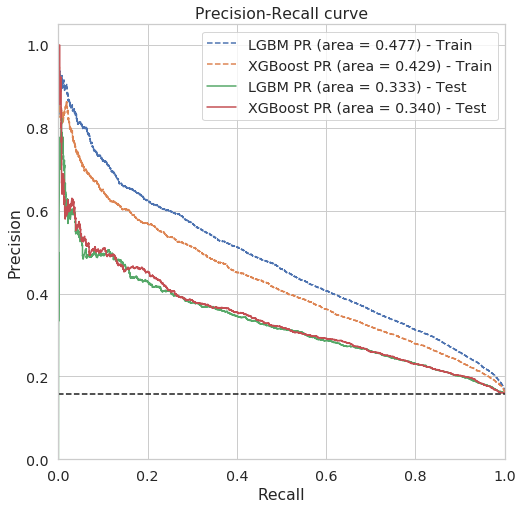

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
plt.figure(figsize=(8,8))
# Include the target only in the training phase
my_selector = selector(training_columns=list(feature_columns) + ['default'],
                       predict_columns=list(feature_columns)) 

xgb_pipeline = build_pipeline(
    my_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
    my_binary_encoder, my_label_encoder,
    my_xgb
)

lgbm_pipeline = build_pipeline(
    my_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
    my_binary_encoder, my_label_encoder,
    my_lgbm
)

# Train the models
(pred_fn_lgbm, lgbm_out, lgbm_log) = lgbm_pipeline(X_train)
(pred_fn_xgb, xgb_out, xgb_log) = xgb_pipeline(X_train)

# Train set evaluation
for (train_out, model_name) in zip([lgbm_out, xgb_out],
                                   ['LGBM', 'XGBoost']):
    precision, recall, _ = precision_recall_curve(y_train, train_out['prediction'])
    roc_auc = auc(recall, precision)
    plt.plot(recall, precision, '--', label='%s PR (area = %0.3f) - Train' % (model_name, roc_auc))

# Test set evaluation
for (pred_fn, model_name) in zip([pred_fn_lgbm, pred_fn_xgb,],
                                 ['LGBM', 'XGBoost']):
    precision, recall, _ = precision_recall_curve(y_test, pred_fn(X_test)['prediction'])
    roc_auc = auc(recall, precision)
    plt.plot(recall, precision, label='%s PR (area = %0.3f) - Test' % (model_name, roc_auc))

# Plot the "no skill" reference line
y = y_test.values
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

# Feature Importance
In `fklearn`, the feature importances are obtained using the method `get_score()` of the XGBoost model API with the parameter `importance_type='weight'`, i.e., the importance is measure by the number of times a feature was used to split the data across all trees. 

It is interesting to see that the top-7 features are all continuous and that `n_bankruptcies` and `n_defaulted_loans` are down in the ranking.

In [30]:
pd.Series(xgb_log['xgb_classification_learner']['feature_importance']).sort_values(ascending=False)

income                        341
amount_borrowed               290
score_6                       268
score_4                       242
score_5                       241
score_3                       170
risk_rate                     140
score_1                       116
n_accounts                    111
score_2                       109
facebook_profile              102
gender                         65
borrowed_in_months             35
real_state                     32
fklearn_feat__state==2         28
fklearn_feat__zip==7           28
fklearn_feat__state==6         22
fklearn_feat__job_name==12     21
fklearn_feat__state==4         19
fklearn_feat__job_name==7      19
fklearn_feat__state==3         16
fklearn_feat__zip==9           16
fklearn_feat__job_name==4      14
fklearn_feat__zip==1           13
fklearn_feat__reason==6        13
fklearn_feat__reason==4        12
fklearn_feat__zip==6           12
fklearn_feat__job_name==3      11
fklearn_feat__job_name==2      11
fklearn_feat__

# Generate the predictions

In [31]:
df_test = pd.read_csv('puzzle_test_dataset.csv')
output_df = pd.DataFrame({
    'ids': df_test.ids,
    'prediction': pred_fn_xgb(df_test)['prediction']
})
output_df.to_csv('predictions.csv', index=False)